# **Horses and Humans Classifier**

In [148]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.saving import save_model

To implement **CNN (Convolution Neural Network)** $\rightarrow$ Use **convolutional** layers in the model definition and also add pooling layers.

Convolution layer with 2D filters: `tf.keras.layers.Conv2D`

This accepts as parameters:
- The number of convolutions to use in the layer
- The size of convolutions
- The activation function
- ...

In [131]:
tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1))

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Conv2D name=conv2d_82, built=False>

In this case, we want the layer to learn `64` convolutions. 
- It will **randomly initialize** these, and over time will learn **the filter values** that **work best** to match the input values to their labels.
- The **(3, 3)** indicates **the size of the filter**. This is the most common size of filter. But you'll typically see an **odd** number of axes like 5x5 or 7x7 because of how filters remove pixels from the borders of the image.
- Because **Conv2D** layers are designed for **multicolor images**, we're specifying the third dimension as 3 because the color images will typically have a 3 as third parameter as they are stored as values of R, G and B.

Use a `pooling` layer in **CNN** -> do this immediately after the convolution layer.

In [132]:
tf.keras.layers.MaxPooling2D(2, 2)

<MaxPooling2D name=max_pooling2d_81, built=True>

### **Load the dataset**

**The Horses and Humans Dataset**

The dataset contains over a thousand 300x300-pixel images, approximately half each of horses and humans, rendered in different poses, orientations and the image composition varies. 

<center>

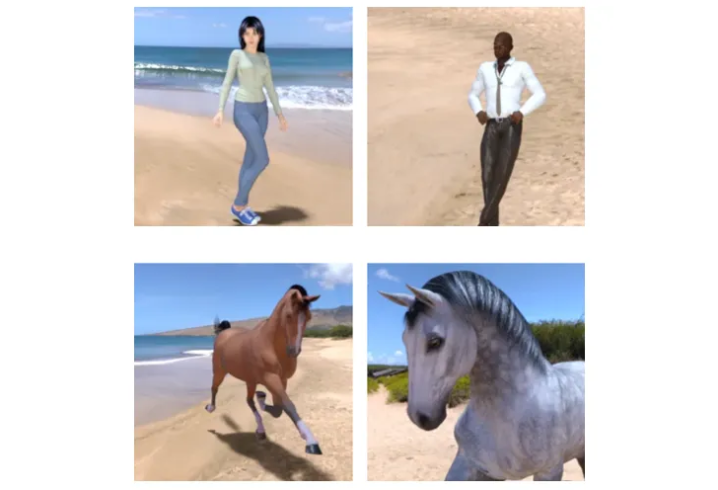
<caption>Horses and Humans</caption>

</center>

In [133]:
training_dir = 'data/horse-or-human/train/'
validation_dir = 'data/horse-or-human/validation/'

# Image augmentation & rescaling
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.1)  # 10% for validation
test_datagen = ImageDataGenerator(rescale=1/255)  # No split needed for test set

# Training generator (90% of the data)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    subset="training",  # Training subset
    shuffle=True,
    seed=42
)

# Validation generator (10% of the training data)
validation_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    subset="validation",  # Validation subset
    shuffle=True,
    seed=42
)

# Test generator (from the separate validation directory)
test_generator = test_datagen.flow_from_directory(
    validation_dir,  # This should be your actual test set directory
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Verify dataset sizes
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 925 images belonging to 2 classes.
Found 102 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Training samples: 925
Validation samples: 102
Test samples: 256


**Note about ImageDataGenerator**

Using the ImageDataGenerator to provide the images the labeling is done automatically, so multiple categories will work the same as binary ones—the ImageDataGenerator will simply label based on the number of subdirectories.

### **CNN Architecture for Horses or Humans**

**Note**

1. The images are much larger - 300 x 300 pixels - so more layers may be needed.

$\quad \Rightarrow$ Stack several more convolution layers and we want, over time, to have many smaller images, each with features highlighted.

2. The images are full color (not grayscale anymore) so each image will have three channels instead of one.
3. There are only two image types, so we have a binary classifier that can be implemented using just a single output neuron, where it approaches 0 for 1 class and 1 for the other. 

**The model architecture**

In [134]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu, input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [135]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_83 (Conv2D)              │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

To train => have to compile it with a **loss function** and an **optimizer**.

In this case, the **loss function** can be **binary cross entropy** because there're only 2 classes, and as the name suggests, this is a loss function that is designed for that scenario.

Try a new optimizer, **root mean square propagation (RMSprop)**, that takes a learning rate (**lr**) parameter that allow us to tweak the learning.

In [136]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [137]:
history = model.fit(train_generator, epochs=3)

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 753ms/step - accuracy: 0.5474 - loss: 1.7127
Epoch 2/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 475ms/step - accuracy: 0.7958 - loss: 0.4225
Epoch 3/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step - accuracy: 0.9072 - loss: 0.2764


**Visualize the result**

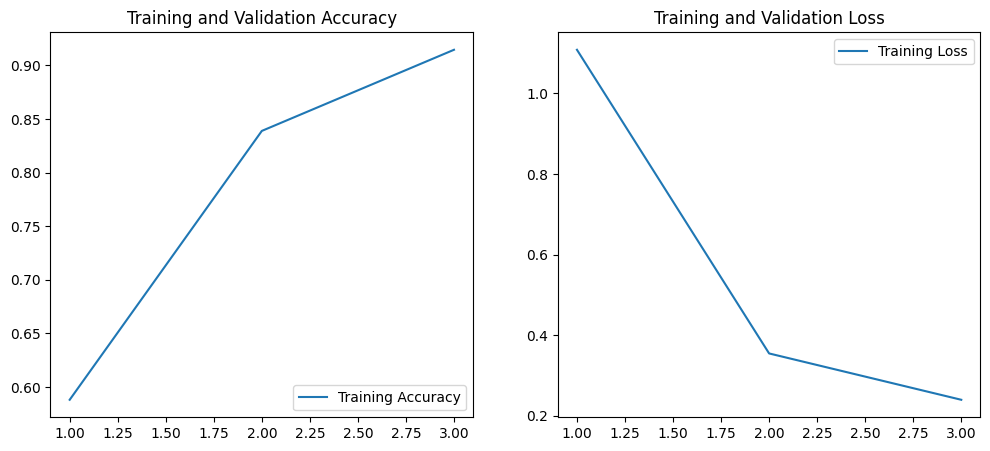

In [138]:
# Extract history data
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

**Predict**

In [139]:
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int")  # Convert probabilities to binary labels

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

print(class_labels)

# Map predicted classes to labels
predicted_labels = [class_labels[i] for i in predicted_classes.flatten()]

# Get image filenames
filenames = validation_generator.filenames  # List of image file names

# Print results
for filename, label in zip(filenames, predicted_labels):
    print(f"{filename}: {label}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step  
['horses', 'humans']
horses\horse01-0.png: horses
horses\horse01-1.png: humans
horses\horse01-2.png: humans
horses\horse01-3.png: horses
horses\horse01-4.png: horses
horses\horse01-5.png: horses
horses\horse01-6.png: humans
horses\horse01-7.png: horses
horses\horse01-8.png: humans
horses\horse01-9.png: horses
horses\horse02-0.png: horses
horses\horse02-1.png: horses
horses\horse02-2.png: humans
horses\horse02-3.png: humans
horses\horse02-4.png: humans
horses\horse02-5.png: horses
horses\horse02-6.png: humans
horses\horse02-7.png: horses
horses\horse02-8.png: horses
horses\horse02-9.png: horses
horses\horse03-0.png: humans
horses\horse03-1.png: humans
horses\horse03-2.png: horses
horses\horse03-3.png: humans
horses\horse03-4.png: humans
horses\horse03-5.png: humans
horses\horse03-6.png: humans
horses\horse03-7.png: humans
horses\horse03-8.png: horses
horses\horse03-9.png: horses
horses\horse04-0.png: humans
horses\horse04-1.png: horses
horses\horse0

In [140]:
true_classes = validation_generator.classes  

# Compute accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Prediction Accuracy: {accuracy:.2%}")  

Prediction Accuracy: 54.90%


### **Adding Validation to the Horses or Humans Dataset**

**Why is about a validation dataset here, rather than a test dataset, and whether they're the same thing?**

**For simple models**, it's often sufficient to split the dataset into two parts, one for training and one for testing.

But **for more complex models**, you'll want to create separate validation and test sets.

**What's the difference?**
- ***Training data*** is the data that is used to teach the network how the data and labels fit together.
- ***Validation data*** is used to see how the network is doing with previously unseen data while you are training. - i.e., it is not used for fitting data to labels, but to inspect how well the fitting is going.
- ***Test data*** is used after training to see how the network does with data it has never previously seen.

Some datasets come with the three-way split, and in other cases, to separate the test set into 2 parts for validation and testing.

In [141]:
model_temp = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu, input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [142]:
model_temp.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [143]:
history = model_temp.fit(train_generator, validation_data=validation_generator, epochs=3)

Epoch 1/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 489ms/step - accuracy: 0.5086 - loss: 1.0373 - val_accuracy: 0.6863 - val_loss: 0.5633
Epoch 2/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - accuracy: 0.8679 - loss: 0.3614 - val_accuracy: 0.9216 - val_loss: 0.2184
Epoch 3/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 476ms/step - accuracy: 0.9321 - loss: 0.1657 - val_accuracy: 0.6961 - val_loss: 1.7092


**Visualize the training result**

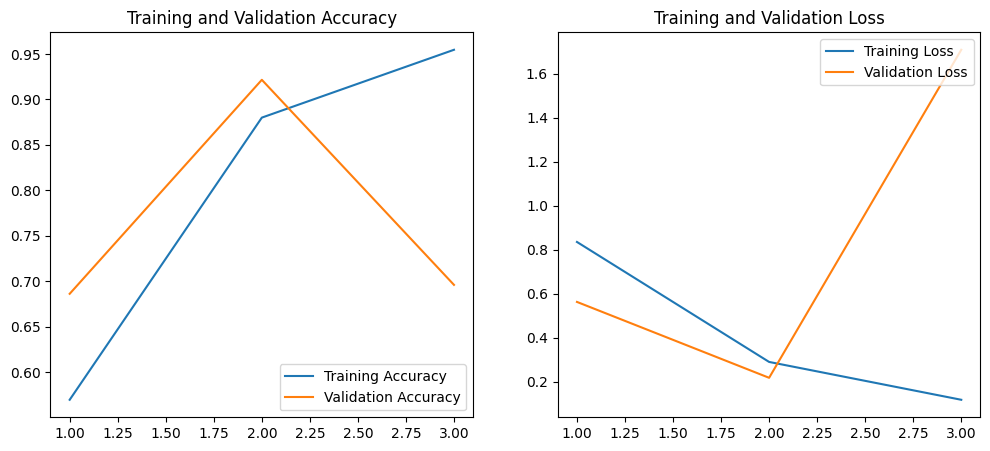

In [144]:
# Extract history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [145]:
predictions = model_temp.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int")  # Convert probabilities to binary labels

# Get class labels
class_labels = list(test_generator.class_indices.keys())

print(class_labels)

# Map predicted classes to labels
predicted_labels = [class_labels[i] for i in predicted_classes.flatten()]

# Get image filenames
filenames = test_generator.filenames  # List of image file names

# Print results
for filename, label in zip(filenames, predicted_labels):
    print(f"{filename}: {label}")

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step
['horses', 'humans']
horses\horse1-000.png: horses
horses\horse1-105.png: horses
horses\horse1-122.png: horses
horses\horse1-127.png: horses
horses\horse1-170.png: humans
horses\horse1-204.png: horses
horses\horse1-224.png: horses
horses\horse1-241.png: horses
horses\horse1-264.png: horses
horses\horse1-276.png: horses
horses\horse1-298.png: horses
horses\horse1-335.png: horses
horses\horse1-384.png: horses
horses\horse1-411.png: horses
horses\horse1-436.png: horses
horses\horse1-455.png: horses
horses\horse1-484.png: horses
horses\horse1-510.png: horses
horses\horse1-539.png: horses
horses\horse1-554.png: humans
horses\horse1-568.png: horses
horses\horse2-011.png: horses
horses\horse2-040.png: horses
horses\horse2-069.png: humans
horses\horse2-112.png: humans
horses\horse2-136.png: humans
horses\horse2-183.png: humans
horses\horse2-201.png: humans
horses\horse2-218.png: horses
horses\horse2-224.png: horses
horses\horse2-254.png: horses
horses\hor

In [152]:
true_classes = test_generator.classes  

# Compute accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Prediction Accuracy: {accuracy:.2%}")  

Prediction Accuracy: 82.81%


**Save models**

In [149]:
save_model(model, "horses-and-humans-wo-validation.keras")
save_model(model_temp, "horses-and-humans-w-validation.keras")